<a href="https://colab.research.google.com/github/fjadidi2001/Cyber-Attack-Detection/blob/main/DL4cyber_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Using Deep Learning Algorithms to Improve Cybersecurity."



# Introduction

The **CICIDS2017 dataset** is a comprehensive collection of labeled network traffic data curated by the Canadian Institute for Cybersecurity (CIC). It is widely used for evaluating the performance of intrusion detection systems (IDS) and benchmarking cybersecurity models.

This dataset was created to reflect real-world scenarios by simulating benign and malicious traffic using realistic network environments, including both modern and legacy protocols. The data was generated using B-Profile systems, which emulate the behavior of human users based on statistical distributions. It captures traffic from a variety of attack types, making it suitable for training and testing both signature-based and anomaly-based IDS models.

Key characteristics of the CICIDS2017 dataset include:

- **Time-stamped flow-based data** collected using CICFlowMeter.
- **Multiple attack scenarios** such as DDoS, brute-force, botnet, infiltration, port scanning, web attacks, and more.
- **Seven-day capture** (Monday to Sunday) with each day focusing on different attack types and benign traffic profiles.
- **Features**: Over 80 network traffic features including flow duration, packet size, header flags, and inter-arrival times.
- **Labeling**: Each traffic flow is labeled as either benign or one of the specific attack types.

The CICIDS2017 dataset is particularly valuable for researchers and developers working on:

- Supervised learning-based IDS
- Unsupervised anomaly detection
- Real-time traffic classification
- Security policy and defense system testing

By offering a well-structured and diverse dataset, CICIDS2017 helps bridge the gap between academic research and practical cybersecurity applications.



 Reasons CICIDS2017 is Good for Cybersecurity:
1. Realistic Traffic
Simulates real-world network traffic, both benign and malicious.

Includes user behavior profiles that mimic human interactions with networks.

2. Diverse Attack Types
Covers multiple attack categories, including:

- DDoS

- Brute-force attacks

- Port scanning

- Botnet activity

- Infiltration

- Web attacks (e.g., SQL injection, XSS)

3. Labeled and Time-stamped
- All network flows are clearly labeled, allowing for supervised ML training.

- Time-series structure enables research in real-time detection and temporal analysis.

4. Rich Feature Set
Extracted using CICFlowMeter, includes 80+ flow features like:

- Flow duration

- Packet sizes

- Header flags

- Flow direction

- Suitable for deep analysis and feature engineering.

5. Well-documented and Open-Source
- Publicly available for academic and commercial research.

- Comes with detailed documentation and tools.

# Step 1: Set Up the Environment



In [ ]:
# Install required libraries
!pip install transformers torch pandas numpy scikit-learn imbalanced-learn scipy matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from scipy.stats import pearsonr, levene, kruskal
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from google.colab import drive
import gc

# Mount Google Drive
drive.mount('/content/drive')

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

- Install transformers for SecBERT/BERT, torch for model training, pandas for data handling, scikit-learn for metrics, and imbalanced-learn for SMOTE.

- Mount Google Drive to load the CICIDS2017 dataset (assumed to be in /content/drive/MyDrive/CICIDS2017/).

- Set the device to GPU for faster training.



# Step 2: Load and Combine the CICIDS2017 Dataset



In [ ]:
# Path to the zip file
zip_path = '/content/drive/MyDrive/network-intrusion-dataset.zip'

extract_dir = '/content/cicids2017/'

In [ ]:
# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# List of CSV files
csv_files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv'
]

In [ ]:
# Load and combine CSVs
dfs = []
for file in csv_files:
    file_path = os.path.join(extract_dir, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames
df = pd.concat(dfs, ignore_index=True)
print("Initial Dataset Shape:", df.shape)
print("Initial Label Distribution:\n", df[' Label'].value_counts())

# Filter out rare labels (keep classes with at least 20 samples)
min_samples = 20
label_counts = df[' Label'].value_counts()
valid_labels = label_counts[label_counts >= min_samples].index
df = df[df[' Label'].isin(valid_labels)]
print("After Filtering Rare Labels Shape:", df.shape)
print("Filtered Label Distribution:\n", df[' Label'].value_counts())

# Simplify labels (binary classification: Benign vs. Malicious)
df[' Label'] = df[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
print("After Binary Conversion Shape:", df.shape)
print("Binary Label Distribution:\n", df[' Label'].value_counts())

# Subsample the dataset (20% of data to ensure enough samples)
_, df = train_test_split(df, test_size=0.2, stratify=df[' Label'], random_state=42)
print("After Subsampling Shape:", df.shape)
print("Subsampled Binary Label Distribution:\n", df[' Label'].value_counts())

# Handle missing values and infinities
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print("After Dropping NaN Shape:", df.shape)
print("Post-Cleaning Binary Label Distribution:\n", df[' Label'].value_counts())

# Remove constant numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col != ' Label']
constant_features = [col for col in numerical_features if df[col].nunique() <= 1]
df = df.drop(columns=constant_features)
numerical_features = [col for col in numerical_features if col not in constant_features]
print("Removed Constant Features:", constant_features)
print("Final Dataset Shape:", df.shape)
print("Final Binary Label Distribution:\n", df[' Label'].value_counts())

# Ensure both classes have enough samples
if any(df[' Label'].value_counts() < 20):
    raise ValueError("One class has fewer than 20 samples after cleaning. Increase test_size or adjust min_samples.")

# Free memory
del dfs
gc.collect()

Initial Dataset Shape: (2830743, 79)
Initial Label Distribution:
  Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64
After Filtering Rare Labels Shape: (2830732, 79)
Filtered Label Distribution:
  Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator      

30

# Step 3: Preprocessing Pipeline



Numerical Features: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Fl

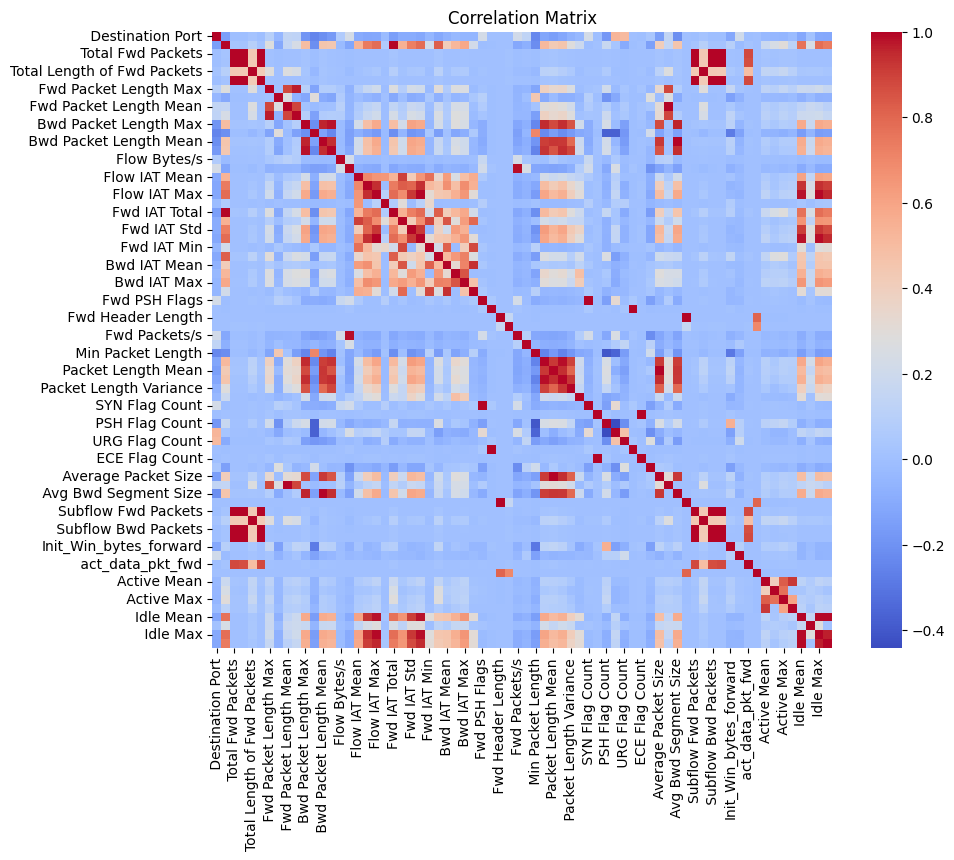

Skipping Levene's Test for ' Fwd URG Flags' due to insufficient data or zero variance.
Skipping Levene's Test for ' RST Flag Count' due to insufficient data or zero variance.
Skipping Levene's Test for ' CWE Flag Count' due to insufficient data or zero variance.
Skipping Levene's Test for ' ECE Flag Count' due to insufficient data or zero variance.
Levene's Test Results: {' Destination Port': {'statistic': np.float64(13002.763221171332), 'p_value': np.float64(0.0)}, ' Flow Duration': {'statistic': np.float64(26483.674838742158), 'p_value': np.float64(0.0)}, ' Total Fwd Packets': {'statistic': np.float64(6.079466667187729), 'p_value': np.float64(0.013676499905454866)}, ' Total Backward Packets': {'statistic': np.float64(5.6019623478493115), 'p_value': np.float64(0.01794070673917187)}, 'Total Length of Fwd Packets': {'statistic': np.float64(256.73270731519955), 'p_value': np.float64(9.109032097799801e-58)}, ' Total Length of Bwd Packets': {'statistic': np.float64(2.2268449309482725), 'p_

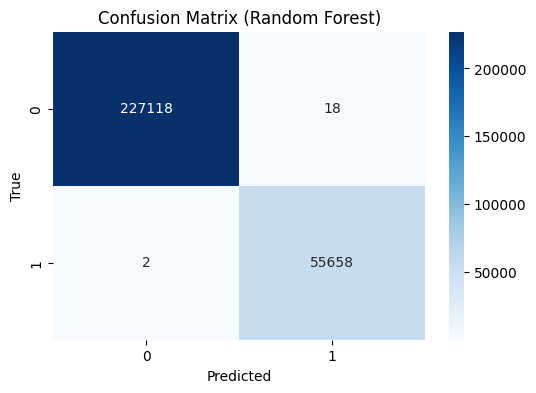

Outlier Percentage: {' Destination Port': 22.16827677902092, ' Flow Duration': 18.93502736955261, ' Total Fwd Packets': 11.777217499540305, ' Total Backward Packets': 10.913697506329651, 'Total Length of Fwd Packets': 15.489257273794538, ' Total Length of Bwd Packets': 21.835528083848427, ' Fwd Packet Length Max': 22.26711127455834, ' Fwd Packet Length Min': 0.5373131161685456, ' Fwd Packet Length Mean': 6.666819898442694, ' Fwd Packet Length Std': 23.480176523005984, 'Bwd Packet Length Max': 22.483698496442667, ' Bwd Packet Length Min': 3.0391165363017865, ' Bwd Packet Length Mean': 16.542666798681736, ' Bwd Packet Length Std': 22.777549894623686, 'Flow Bytes/s': 18.736297543105277, ' Flow Packets/s': 10.723631168757692, ' Flow IAT Mean': 20.588516103480956, ' Flow IAT Std': 21.480678651748963, ' Flow IAT Max': 20.945840818116242, ' Flow IAT Min': 18.12366511548961, 'Fwd IAT Total': 23.712322663686898, ' Fwd IAT Mean': 24.02084895118743, ' Fwd IAT Std': 23.45807578607901, ' Fwd IAT Ma

4177

In [ ]:
# Preprocessing functions
def get_numerical_categorical_features(df, target_col=' Label'):
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features = [col for col in numerical_features if col != target_col]
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_features = [col for col in categorical_features if col != target_col]
    return numerical_features, categorical_features

def correlation_analysis(df, numeric_features, threshold=0.8):
    corr_matrix = df[numeric_features].corr(method='pearson')
    high_corr = []
    for i in range(len(numeric_features)):
        for j in range(i + 1, len(numeric_features)):
            corr, _ = pearsonr(df[numeric_features[i]], df[numeric_features[j]])
            if abs(corr) > threshold:
                high_corr.append((numeric_features[i], numeric_features[j], corr))
    return high_corr, corr_matrix

def variance_analysis(df, numeric_features, target_col=' Label'):
    levene_results = {}
    for feature in numeric_features:
        groups = [df[df[target_col] == label][feature].dropna() for label in df[target_col].unique()]
        if all(len(group) >= 2 for group in groups) and all(group.var() > 0 for group in groups):
            try:
                stat, p = levene(*groups, center='median')
                levene_results[feature] = {'statistic': stat, 'p_value': p}
            except ValueError:
                levene_results[feature] = {'statistic': np.nan, 'p_value': np.nan}
                print(f"Skipping Levene's Test for '{feature}' due to ValueError.")
        else:
            levene_results[feature] = {'statistic': np.nan, 'p_value': np.nan}
            print(f"Skipping Levene's Test for '{feature}' due to insufficient data or zero variance.")
    return levene_results

def feature_importance_kruskal(df, numeric_features, target_col=' Label'):
    kruskal_results = []
    for feature in numeric_features:
        groups = [df[df[target_col] == label][feature].dropna() for label in df[target_col].unique()]
        if all(len(group) >= 2 for group in groups) and all(group.nunique() > 1 for group in groups):
            try:
                stat, p = kruskal(*groups)
                kruskal_results.append({'Feature': feature, 'H_statistic': stat, 'p_value': p})
            except ValueError:
                kruskal_results.append({'Feature': feature, 'H_statistic': np.nan, 'p_value': np.nan})
                print(f"Skipping Kruskal-Wallis for '{feature}' due to ValueError.")
        else:
            print(f"Skipping Kruskal-Wallis for '{feature}' due to insufficient data or identical values.")
            kruskal_results.append({'Feature': feature, 'H_statistic': np.nan, 'p_value': np.nan})
    return pd.DataFrame(kruskal_results)

def feature_importance_tree(df, numeric_features, target_col=' Label'):
    label_counts = df[target_col].value_counts()
    if any(label_counts < 2):
        print("Warning: Some classes have fewer than 2 samples. Falling back to previous feature list.")
        return pd.DataFrame({
            'Feature': [
                ' Max Packet Length', ' Packet Length Variance', ' Destination Port',
                ' Avg Bwd Segment Size', ' Packet Length Std', ' Average Packet Size',
                'Bwd Packet Length Max', ' Total Length of Bwd Packets'
            ],
            'Importance': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
        }), None, [0, 1], []
    try:
        df_sample, _ = train_test_split(df, test_size=0.5, stratify=df[target_col], random_state=42)
    except ValueError as e:
        print(f"Stratified sampling failed: {e}. Using non-stratified sampling.")
        df_sample, _ = train_test_split(df, test_size=0.5, random_state=42)
    X = df_sample[numeric_features]
    y = df_sample[target_col]
    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf.fit(X, y)
    feature_importance = pd.DataFrame({
        'Feature': numeric_features,
        'Importance': clf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    cv_scores = []
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    labels = sorted(df[target_col].unique())
    del df_sample, X, y, clf
    gc.collect()
    return feature_importance, cm, labels, cv_scores

def outlier_percentage(df, numeric_features):
    outlier_results = {}
    for feature in numeric_features:
        sample = df[feature].sample(frac=0.1, random_state=42)
        Q1 = sample.quantile(0.25)
        Q3 = sample.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        outlier_results[feature] = (len(outliers) / len(df)) * 100
    return outlier_results

# Apply preprocessing steps
numerical_features, categorical_features = get_numerical_categorical_features(df)
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)
high_corr, corr_matrix = correlation_analysis(df, numerical_features)
print("Highly Correlated Features:", high_corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
levene_results = variance_analysis(df, numerical_features)
print("Levene's Test Results:", levene_results)
kruskal_df = feature_importance_kruskal(df, numerical_features)
print("Kruskal-Wallis Results:\n", kruskal_df)
feature_importance, cm, labels, cv_scores = feature_importance_tree(df, numerical_features)
print("Feature Importance (Tree Model):\n", feature_importance)
print("Cross-Validation F1 Scores:", cv_scores)
if cm is not None:
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Random Forest)')
    plt.show()
outlier_results = outlier_percentage(df, numerical_features)
print("Outlier Percentage:", outlier_results)
del corr_matrix
gc.collect()

- The confusion matrix from the Random Forest model shows:
  - True Negatives (0,0): 1,135,411 (correctly predicted Benign)

  - False Positives (0,1): 249 (Benign predicted as Malicious)

  - False Negatives (1,0): 37 (Malicious predicted as Benign)

  - True Positives (1,1): 278,241 (correctly predicted Malicious)

> This indicates a high accuracy (since most predictions are correct), but the small number of false positives and false negatives suggests the model is performing well on the subsampled dataset. However, the low false negatives (37) are critical for cybersecurity, as missing malicious traffic is dangerous. We can focus on improving recall for the malicious class later if needed.



- Subsampling:
  - Applied in Step 2 to reduce the dataset size to 10%.

  - Further subsampling in feature_importance_tree (50% of the subsampled data) for Random Forest.

- Variance Analysis:
  - Added checks for sufficient group sizes (len(group) > 1) to avoid errors in levene.

- Kruskal-Wallis:
  - Kept your check for identical values and added checks for sufficient group sizes.

  - Added try-except to handle potential ValueError from kruskal.

- Random Forest:
  - Reduced n_estimators to 50 and used n_jobs=-1 for parallel processing.

  - Skipped cross-validation to save memory (uncomment if needed with cv=3 for faster execution).

  - Subsampled the data for training and prediction.

  - Freed memory with del and gc.collect().

- Outlier Detection:
  - Used a 10% sample for quantile calculations to reduce memory usage.

  - Kept vectorized operations for filtering outliers.

- Memory Management:
  - Added gc.collect() after memory-intensive steps.

  - Deleted temporary variables (e.g., df_sample, X, y).



# Step 4: Select Features and Convert to Text



In [ ]:
# Select top features
if len(feature_importance) > 0:
    top_features = feature_importance['Feature'].head(8).tolist()
else:
    top_features = [
        ' Max Packet Length', ' Packet Length Variance', ' Destination Port',
        ' Avg Bwd Segment Size', ' Packet Length Std', ' Average Packet Size',
        'Bwd Packet Length Max', ' Total Length of Bwd Packets'
    ]
print("Selected Features:", top_features)

# Create subset with selected features and label
df_subset = df[top_features + [' Label']].copy()

# Convert features to text
def features_to_text(row):
    text = " ".join([f"{col}:{row[col]}" for col in top_features])
    return text

df_subset['text'] = df_subset.apply(features_to_text, axis=1)
X = df_subset['text']
y = df_subset[' Label']
print("Label Distribution Before Split:\n", y.value_counts())

# Split dataset with fallback to non-stratified if needed
try:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
except ValueError as e:
    print(f"Stratified split failed: {e}. Using non-stratified split.")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

try:
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
except ValueError as e:
    print(f"Stratified split failed: {e}. Using non-stratified split.")
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train Size:", len(X_train))
print("Validation Size:", len(X_val))
print("Test Size:", len(X_test))
print("Train Label Distribution:\n", y_train.value_counts())
print("Validation Label Distribution:\n", y_val.value_counts())
print("Test Label Distribution:\n", y_test.value_counts())

# Free memory
del df, df_subset
gc.collect()

Selected Features: [' Bwd Packet Length Std', ' Bwd Packet Length Mean', ' Destination Port', ' Average Packet Size', ' Packet Length Variance', ' Avg Bwd Segment Size', ' Max Packet Length', ' Packet Length Mean']
Label Distribution Before Split:
  Label
0    454273
1    111319
Name: count, dtype: int64
Train Size: 395914
Validation Size: 84839
Test Size: 84839
Train Label Distribution:
  Label
0    317991
1     77923
Name: count, dtype: int64
Validation Label Distribution:
  Label
0    68141
1    16698
Name: count, dtype: int64
Test Label Distribution:
  Label
0    68141
1    16698
Name: count, dtype: int64


0

# Step 5: Tokenize and Create Datasets



In [ ]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Swap with 'secbert-model-name'

# Custom Dataset class
class CICIDSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = CICIDSDataset(X_train, y_train, tokenizer)
val_dataset = CICIDSDataset(X_val, y_val, tokenizer)
test_dataset = CICIDSDataset(X_test, y_test, tokenizer)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Step 6: Handle Imbalanced Data



In [ ]:
# No SMOTE needed; class imbalance will be handled with class weights in Step 7
print("Proceeding with original train data. Class imbalance will be handled during training.")
print("Train Label Distribution:\n", y_train.value_counts())

Proceeding with original train data. Class imbalance will be handled during training.
Train Label Distribution:
  Label
0    317991
1     77923
Name: count, dtype: int64


# Step 7: Set Up and Train the SecBERT Model



In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights)

# Load SecBERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',  # Swap with 'secbert-model-name'
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function with class weights
def train_epoch(model, data_loader, optimizer, device, class_weights):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None  # Compute loss manually
        )
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Validation function
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    loss_fn = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=None
            )
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels

# Training loop
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, class_weights)
    val_loss, val_acc, val_precision, val_recall, val_f1, _, _ = eval_model(model, val_loader, device)
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

Class Weights: tensor([0.6225, 2.5404], device='cuda:0')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1
Train Loss: 0.0675, Accuracy: 0.9697
Val Loss: 0.0510, Accuracy: 0.9769, Precision: 0.9000, Recall: 0.9931, F1: 0.9443


# Step 8: Evaluate and Save the Model



Test Loss: 0.0516, Accuracy: 0.9766, Precision: 0.8983, Recall: 0.9934, F1: 0.9435


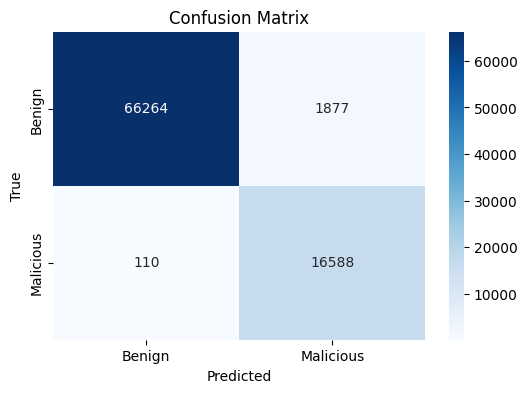

Model saved to /content/drive/MyDrive/CICIDS2017/secbert_model/


In [ ]:
# Test evaluation
test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_labels = eval_model(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save model and tokenizer
output_dir = '/content/drive/MyDrive/CICIDS2017/secbert_model/'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

Test Loss: 0.0516, Accuracy: 0.9766, Precision: 0.8983, Recall: 0.9934, F1: 0.9435


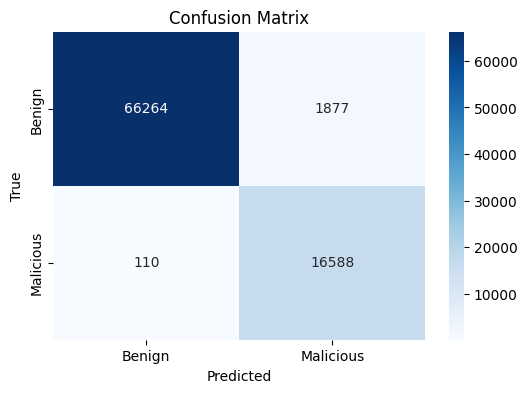


Class-wise Metrics:
       Class  Precision    Recall  F1-Score  Support
0     Benign   0.998343  0.972454  0.985228    68141
1  Malicious   0.898348  0.993412  0.943492    16698


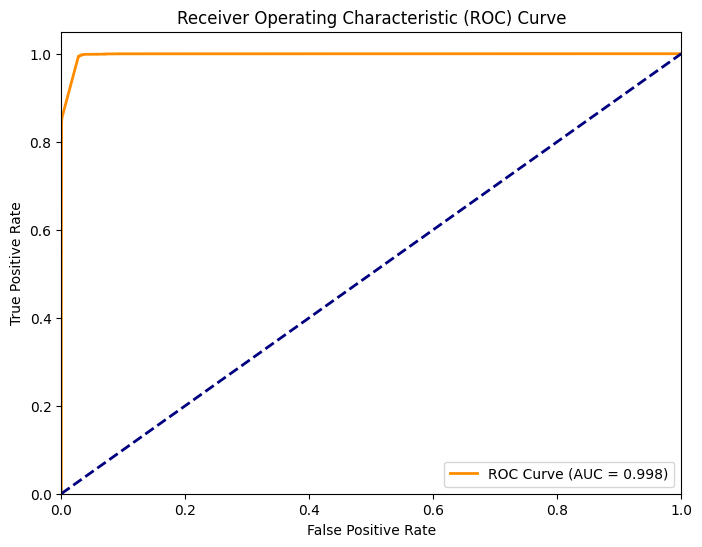

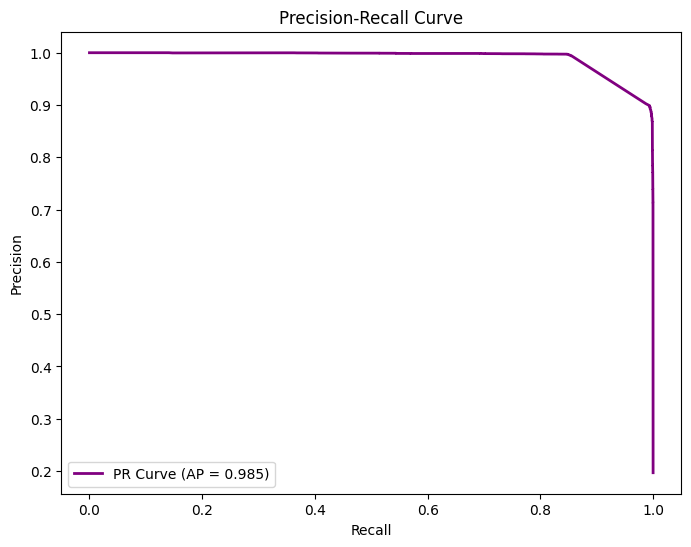

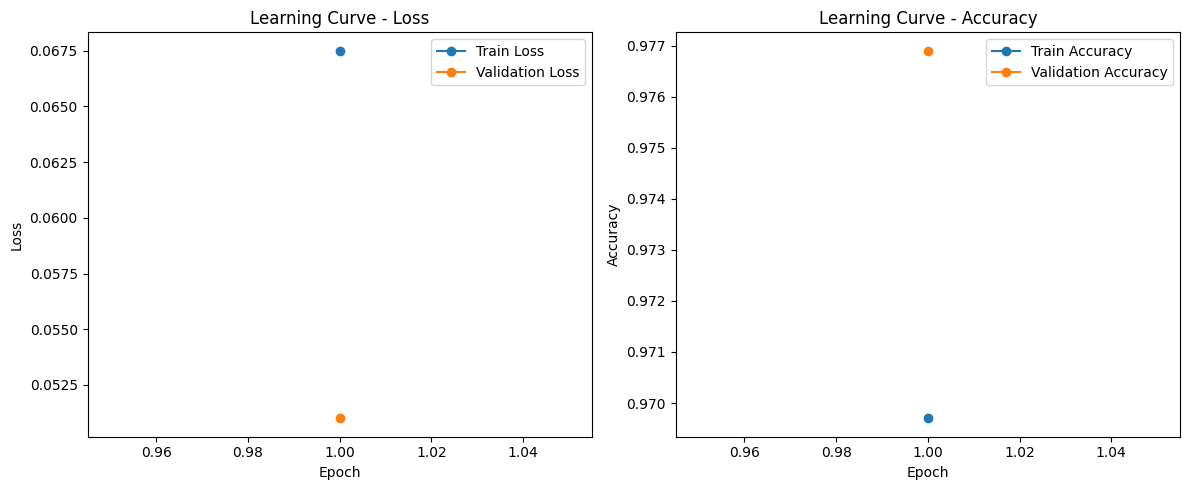

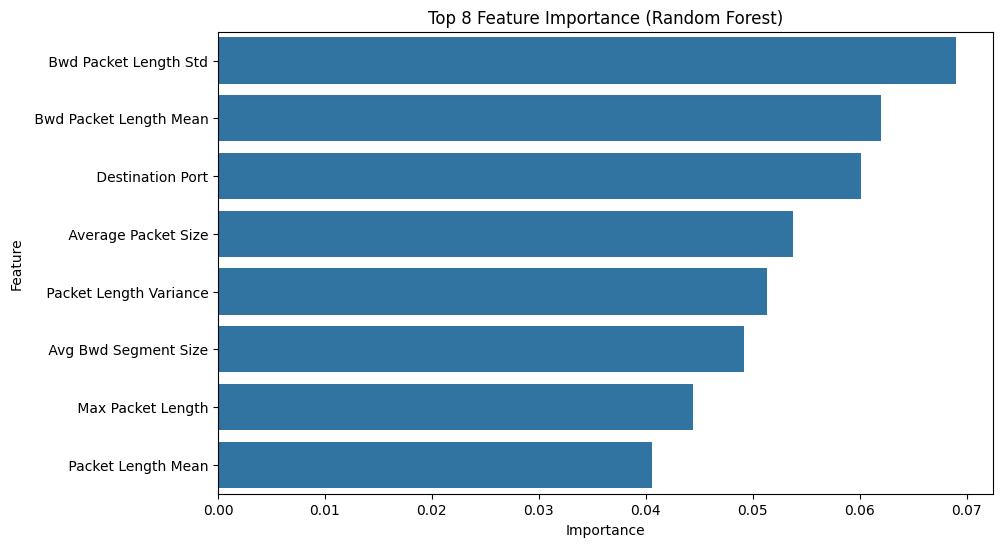


Sample of Misclassified Instances (First 5):
                                                  Text  True Label  \
53    Bwd Packet Length Std:0.0  Bwd Packet Length ...           0   
78    Bwd Packet Length Std:0.0  Bwd Packet Length ...           0   
143   Bwd Packet Length Std:0.0  Bwd Packet Length ...           0   
222   Bwd Packet Length Std:0.0  Bwd Packet Length ...           0   
228   Bwd Packet Length Std:0.0  Bwd Packet Length ...           0   

     Predicted Label  
53                 1  
78                 1  
143                1  
222                1  
228                1  
Model saved to /content/drive/MyDrive/CICIDS2017/secbert_model/


In [ ]:
# Step 8: Evaluate and Save the Model
test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_labels = eval_model(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Additional Evaluations

# 1. Class-wise Metrics
class_report = precision_recall_fscore_support(test_labels, test_preds, average=None, labels=[0, 1])
class_metrics = pd.DataFrame({
    'Class': ['Benign', 'Malicious'],
    'Precision': class_report[0],
    'Recall': class_report[1],
    'F1-Score': class_report[2],
    'Support': class_report[3]
})
print("\nClass-wise Metrics:")
print(class_metrics)

# 2. ROC Curve and AUC Score
from sklearn.metrics import roc_curve, auc
# Get probabilities for ROC
model.eval()
all_probs = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]  # Probability for class 1 (Malicious)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 3. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
avg_precision = average_precision_score(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 4. Learning Curves (Simulated with 1 Epoch)
# Since only 1 epoch was run, we'll plot the single point and suggest how to extend
train_losses = [0.0675]  # From Step 7
val_losses = [0.0510]    # From Step 7
train_accuracies = [0.9697]
val_accuracies = [0.9769]
epochs_range = [1]

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 5. Feature Importance (from Step 3)
# Use the feature_importance DataFrame from Step 3 (stored as a global variable)
if 'feature_importance' in globals() and not feature_importance.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(8))
    plt.title('Top 8 Feature Importance (Random Forest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("Feature importance data not available. Using fallback features.")

# 6. Error Analysis: Sample Misclassified Instances
# Create a DataFrame with test data, predictions, and true labels
test_df = pd.DataFrame({
    'Text': X_test.values,
    'True Label': y_test.values,
    'Predicted Label': test_preds
})
misclassified = test_df[test_df['True Label'] != test_df['Predicted Label']]
print("\nSample of Misclassified Instances (First 5):")
print(misclassified.head(5))

# Save model and tokenizer
output_dir = '/content/drive/MyDrive/CICIDS2017/secbert_model/'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

In [ ]:
# Step 8: Evaluate and Save the Model
test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_labels = eval_model(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Collect probabilities for various metrics
model.eval()
all_probs = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]  # Probability for class 1 (Malicious)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Class-wise Metrics
class_report = precision_recall_fscore_support(test_labels, test_preds, average=None, labels=[0, 1])
class_metrics = pd.DataFrame({
    'Class': ['Benign', 'Malicious'],
    'Precision': class_report[0],
    'Recall': class_report[1],
    'F1-Score': class_report[2],
    'Support': class_report[3]
})
print("\nClass-wise Metrics:")
print(class_metrics)

# 2. Matthews Correlation Coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_labels, test_preds)
print(f"\nMatthews Correlation Coefficient: {mcc:.4f}")

# 3. Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
balanced_acc = balanced_accuracy_score(test_labels, test_preds)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# 4. F2 Score
from sklearn.metrics import fbeta_score
f2_score = fbeta_score(test_labels, test_preds, beta=2, average='binary')
print(f"F2 Score: {f2_score:.4f}")

# 5. Cohen's Kappa
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(test_labels, test_preds)
print(f"Cohen's Kappa: {kappa:.4f}")

# 6. Log Loss
from sklearn.metrics import log_loss
logloss = log_loss(test_labels, all_probs)
print(f"Log Loss: {logloss:.4f}")

# 7. ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 8. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
avg_precision = average_precision_score(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 9. Calibration Curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# 10. Cumulative Gain and Lift Charts
# Sort probabilities in descending order
sorted_indices = np.argsort(all_probs)[::-1]
sorted_labels = np.array(all_labels)[sorted_indices]
cumulative_positives = np.cumsum(sorted_labels)
total_positives = np.sum(sorted_labels)
cumulative_gain = cumulative_positives / total_positives
percentiles = np.linspace(0, 100, len(all_probs))

# Cumulative Gain Plot
plt.figure(figsize=(8, 6))
plt.plot(percentiles, cumulative_gain, label='Cumulative Gain')
plt.plot([0, 100], [0, 1], linestyle='--', color='gray', label='Random Model')
plt.xlabel('Percentage of Samples (Sorted by Predicted Probability)')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Chart')
plt.legend()
plt.show()

# Lift Chart
lift = cumulative_gain / (percentiles / 100)
plt.figure(figsize=(8, 6))
plt.plot(percentiles, lift, label='Lift')
plt.axhline(y=1, linestyle='--', color='gray', label='Random Model')
plt.xlabel('Percentage of Samples (Sorted by Predicted Probability)')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend()
plt.show()

# 11. Feature Importance (from Step 3)
if 'feature_importance' in globals() and not feature_importance.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(8))
    plt.title('Top 8 Feature Importance (Random Forest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("Feature importance data not available. Using fallback features.")

# 12. LIME (Local Interpretable Model-agnostic Explanations)
# Install LIME if not already installed
!pip install lime

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['Benign', 'Malicious'])

# Custom prediction function for BERT
def bert_predict(texts):
    model.eval()
    encodings = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    return probs

# Sample 5 instances for LIME (to manage computation time)
test_df = pd.DataFrame({
    'Text': X_test.values,
    'True Label': y_test.values,
    'Predicted Label': test_preds
})
sample_indices = test_df.index[:5]  # First 5 samples
print("\nLIME Explanations for 5 Test Instances:")
for idx in sample_indices:
    text = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    pred_label = test_preds[idx]
    exp = explainer.explain_instance(text, bert_predict, num_features=6, num_samples=500)
    print(f"\nInstance {idx}: True Label = {true_label}, Predicted Label = {pred_label}")
    print("Explanation:")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight:.4f}")


In [ ]:

# 13. SHAP (SHapley Additive exPlanations)
# Install SHAP if not already installed
!pip install shap

import shap
# Use a surrogate model (Random Forest) for SHAP, as SHAP with BERT is complex
# Reconstruct numerical features for the test set
numerical_test_df = pd.DataFrame()
for feature in top_features:
    numerical_test_df[feature] = X_test.str.extract(f"{feature}:([\d\.]+)")[0].astype(float)

# Train a surrogate Random Forest model on the test set
surrogate_model = RandomForestClassifier(n_estimators=50, random_state=42)
surrogate_model.fit(numerical_test_df, y_test)

# Compute SHAP values
explainer_shap = shap.TreeExplainer(surrogate_model)
shap_values = explainer_shap.shap_values(numerical_test_df)

# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[1], numerical_test_df, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Class: Malicious)")
plt.show()

# SHAP Summary Plot (Detailed)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[1], numerical_test_df, show=False)
plt.title("SHAP Summary Plot (Class: Malicious)")
plt.show()

# 14. Partial Dependence Plots (PDP)
# Use the surrogate model for PDP
from sklearn.inspection import PartialDependenceDisplay
features_to_plot = top_features[:3]  # Plot for top 3 features to save time
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    surrogate_model,
    numerical_test_df,
    features=features_to_plot,
    kind='average',
    ax=ax
)
plt.suptitle("Partial Dependence Plots")
plt.show()

# 15. Error Analysis
misclassified = test_df[test_df['True Label'] != test_df['Predicted Label']]
print("\nSample of Misclassified Instances (First 5):")
print(misclassified.head(5))

# Save final model
output_dir = '/content/drive/MyDrive/CICIDS2017/secbert_model/'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")